# Running a SCF

In [ ]:
import Auto_baby

In [ ]:
print(Auto_baby)

In [ ]:
silicon_experiment = Auto_baby.Experiment(material_dir='/home/student/zylu/silicon_demo')

In [ ]:
silicon_experiment.ensure_directories()

In [ ]:
silicon_experiment.ensure_required_files()

In [ ]:
silicon_experiment.scf_calculation()

In [ ]:
silicon_experiment.dos()

In [ ]:
silicon_experiment.band_structure()

# Automation with FireWorks

## Download POSCAR files from MP offical repo and save them to `material_path/POSCAR`

In [16]:
INCAR_SCF = """PREC=accurate
ENCUT=500
NELMIN=10
EDIFF=1E-5
NSW=0
IBRION=-1
ISMEAR=0
SIGMA=0.01
ADDGRID=T
LWAVE=T
LCHARG=T
LREAL=F
LASPH=T
LORBIT=10

KGAMMA=T
KSPACING=0.15
"""

INCAR_DOS = """PREC=accurate
ENCUT=500
NELMIN=10
EDIFF=1E-5
NSW=0
IBRION=-1
ISMEAR=-5
SIGMA=0.01
ADDGRID=T
LCHARG=F
LWAVE=F
LREAL=F
LASPH=T
LORBIT=10

NEDOS=2001
EMAX=20.00
EMIN=-20.00
"""

INCAR_BS = """PREC=accurate
ENCUT=500
NELMIN=10
EDIFF=1E-5
NSW=0
IBRION=-1
ISMEAR=0
SIGMA=0.01
ADDGRID=T
LWAVE=F
LCHARG=F
LREAL=F
LASPH=T
LORBIT=10

ICHARG=11
"""

job_sh_template = """#!/bin/bash
#SBATCH --nodes=1
#SBATCH --ntasks-per-node=8
#SBATCH --partition=g1,g2,g3
##
#SBATCH --job-name=zylu_demo
#SBATCH --time=99-24:59          # Runtime: Day-HH:MM
#SBATCH -o log.txt         # STDOUT
#SBATCH -e error.txt         # STDERR
#################################################################################

#################################################################################
VASP_BIN=/TGM/Apps/VASP/VASP_BIN/6.3.2/vasp.6.3.2.std.x
#################################################################################

hostname
date

#################################################################################
### Module Env
module purge
module add compiler/2022.1.0
module add mkl/2022.1.0
module add mpi/2021.6.0
export OMP_NUM_THREADS=1
export RSH_COMMAND="/usr/bin/ssh -x"
scontrol show hostname ${SLURM_JOB_NODELIST} | perl -ne 'chomb; print "$_"x1'> ${SLURM_SUBMIT_DIR}/nodelist
#################################################################################

mpirun -np $SLURM_NTASKS $VASP_BIN > stdout
"""

KPOINTS = """Automatic mesh
0
Auto
  10

"""

In [17]:
import os
from pathlib import Path

from pymatgen.core import Structure
from pymatgen.io.vasp import Kpoints

def generate_potcar_from_poscar_flat(base_path):
    """
    Concatenates and generates a VASP POTCAR file from a flattened directory structure, based on the list of elements in the POSCAR file.

    Args:

    base_path (str): The root directory for the material calculation. The function assumes the POSCAR is located at base_path/1_scf/POSCAR.

    Returns:

    None. Prints status messages to the console.
    """
    # --- Path Definitions ---
    # The root directory of the POTCAR library, now points directly to your potcars folder.

    pot_path = Path('/TGM/Apps/VASP/POTCAR/1.POTPAW.PBE.VASP64_RECOMMEND/')
    base_path = Path(base_path)
    poscar_path = base_path / '1_scf' / 'POSCAR'
    output_path = base_path / '1_scf' / 'POTCAR'
    
    print(f"Generating POTCAR from {poscar_path} to {output_path}...")

    # --- Reading element symbols from POSCAR file ---
    try:
        with open(poscar_path, 'r') as f:
            lines = f.readlines()
        # In VASP 5+ format, element symbols are on the 6th line (index 5)
        elements = lines[5].strip().split()
        if not elements:
            print(f"Error: No element symbols found on line 6 of POSCAR file '{poscar_path}'.")
            return
        print(f"Elements found in POSCAR: {elements}")
    except FileNotFoundError:
        print(f"Error: File '{poscar_path}' not found.")
        return
    except IndexError:
        print(f"Error: Unable to read element line from '{poscar_path}'. It may not be a valid VASP 5+ format.")
        return

    # --- Concatenating POTCAR files ---
    try:
        with open(output_path, 'wb') as potcar_file:
            for element in elements:
                # *** Main modification part ***
                # Construct the path according to your 'POTCAR' filename format
                element_pot_path = pot_path / element / "POTCAR"

                if not os.path.exists(element_pot_path):
                    print(f"Error: POTCAR file for element '{element}' not found at '{element_pot_path}'")
                    # Clean up partially created file
                    potcar_file.close()
                    os.remove(output_path)
                    return

                with open(element_pot_path, 'rb') as element_file:
                    potcar_file.write(element_file.read())
        
        print(f"Successfully generated POTCAR for elements: {' '.join(elements)} at '{output_path}'")

    except Exception as e:
        print(f"An unexpected error occurred during file writing: {e}")

def create_vasp_project(material_id, material_formula, base_path, POSCAR_content):

    base_dir = os.path.join(base_path, f"{material_id}_{material_formula}")
    scf_dir = os.path.join(base_dir, "1_scf")
    dos_dir = os.path.join(base_dir, "2_dos")
    bs_dir = os.path.join(base_dir, "3_bs") 

    # Create directories
    for d in [base_dir, scf_dir, dos_dir, bs_dir]:
        os.makedirs(d, exist_ok=True)

    # Create POSCAR, INCAR, job.sh in 1_scf directory
    with open(os.path.join(scf_dir, "POSCAR"), "w") as f:
        f.write(f"{POSCAR_content}")
    with open(os.path.join(scf_dir, "INCAR"), "w") as f:
        f.write(INCAR_SCF)
    with open(os.path.join(scf_dir, "job.sh"), "w") as f:
        f.write(job_sh_template)

    # Create INCAR in 2_dos 
    with open(os.path.join(dos_dir, "INCAR"), "w") as f:
        f.write(INCAR_DOS)

    # Create INCAR in 3_bs 
    with open(os.path.join(bs_dir, "INCAR"), "w") as f:
        f.write(INCAR_BS)
    with open(os.path.join(bs_dir, "KPOINTS"),"w") as f:
        f.write(KPOINTS)
    
    generate_potcar_from_poscar_flat(base_path = base_dir)
    print(f"Project structure has been created for {material_id}_{material_formula}.")


## search criteria: ABX3 cubic materials.

cubic perovskite

formula_anonymous: ABO3

In [ ]:
from mp_api.client import MPRester
from emmet.core.symmetry import CrystalSystem

with MPRester("5ypNyStQsaDUA2neNLD17P8v2KNB241U") as mpr:
    
    docs = mpr.materials.summary.search(
        formula=["ABC3"],
        crystal_system=CrystalSystem.cubic,
    )
    print(f"found {len(docs)} ABX3 cubic materials.")


In [18]:
doc = docs[40]
# for doc in docs:
structure = doc.structure
formula = doc.formula_pretty
material_id = doc.material_id

print(f"Processing material: {material_id}, formula: {formula}, material_id: {material_id}")

Processing material: mp-1416557, formula: AlNiO3, material_id: mp-1416557


In [19]:
create_vasp_project(material_id, formula, base_path="/home/student/zylu/materials", POSCAR_content=structure.to(fmt="poscar"))

Generating POTCAR from /home/student/zylu/materials/mp-1416557_AlNiO3/1_scf/POSCAR to /home/student/zylu/materials/mp-1416557_AlNiO3/1_scf/POTCAR...
Elements found in POSCAR: ['Al', 'Ni', 'O']
Successfully generated POTCAR for elements: Al Ni O at '/home/student/zylu/materials/mp-1416557_AlNiO3/1_scf/POTCAR'
Project structure has been created for mp-1416557_AlNiO3.


```
mp-149_Si/
├── 1_scf/
│   ├── INCAR_scf
│   ├── POSCAR
│   ├── POTCAR
│   └── job.sh
├── 2_dos/
│   └── INCAR_dos
└── 3_bs/
    └── INCAR_bs
```



## WorkFlows

In [20]:
from fireworks import Firework, LaunchPad, FileTransferTask, PyTask, Workflow, ScriptTask
from fireworks.core.rocket_launcher import rapidfire
import Auto_baby



launchpad = LaunchPad()
launchpad.reset('', require_password=False)

def Final_Calculation(material_id, formula, material_path:str = ''):
    if not material_path: raise ValueError("material_path must be provided.")


    # launchpad = LaunchPad()
    # launchpad.reset('', require_password=False)
    

    _submit_SCF_Task_ = PyTask(func = "Auto_baby.scf_ready",
                               args=[material_path])



    _transfer_CONTCAR_of_SCF_to_DOS = ScriptTask({'script': f'cp {material_path}/1_scf/CONTCAR {material_path}/2_dos/POSCAR'})

    _transfer_POTCAR_of_SCF_to_DOS = FileTransferTask({'files': [{'src': f'{material_path}/1_scf/POTCAR', 
                                                       'dest': f'{material_path}/2_dos'}], 'mode': 'copy'})
    _transfer_JOB_of_SCF_to_DOS = FileTransferTask({'files': [{'src': f'{material_path}/1_scf/job.sh', 
                                                  'dest': f'{material_path}/2_dos'}], 'mode': 'copy'})
    _transfer_WAVECAR_of_SCF_to_DOS = FileTransferTask({'files': [{'src': f'{material_path}/1_scf/WAVECAR', 
                                                       'dest': f'{material_path}/2_dos'}], 'mode': 'copy'})
    

    _submit_DOS_Task_ = PyTask(func= "Auto_baby.dos_ready",
                               args=[material_path])



    _transfer_CONTCAR_of_SCF_to_BS = ScriptTask({'script': f'cp {material_path}/1_scf/CONTCAR {material_path}/3_bs/POSCAR'})
    _transfer_POTCAR_of_SCF_to_BS = FileTransferTask({'files': [{'src': f'{material_path}/1_scf/POTCAR', 
                                                    'dest': f'{material_path}/3_bs'}], 'mode': 'copy'})
    _transfer_JOB_of_SCF_to_BS = FileTransferTask({'files': [{'src': f'{material_path}/1_scf/job.sh', 
                                                    'dest': f'{material_path}/3_bs'}], 'mode': 'copy'})
    _transfer_CHGCAR_of_SCF_to_BS = FileTransferTask({'files': [{'src': f'{material_path}/1_scf/CHGCAR', 
                                                    'dest': f'{material_path}/3_bs'}], 'mode': 'copy'})
    

    _submit_BS_Task_ = PyTask(func = "Auto_baby.bs_ready",
                             args=[material_path])



    scf_calculation = Firework(
        tasks=[_submit_SCF_Task_],
        name="SCF Calculation" 
    )

    DOS_calculation = Firework(
        tasks=[_transfer_CONTCAR_of_SCF_to_DOS, _transfer_POTCAR_of_SCF_to_DOS, _transfer_JOB_of_SCF_to_DOS, _transfer_WAVECAR_of_SCF_to_DOS,_submit_DOS_Task_],
        name="DOS Calculation",
        parents=[scf_calculation]
    )

    BAND_structure_calculation = Firework(
        tasks=[_transfer_CONTCAR_of_SCF_to_BS, _transfer_POTCAR_of_SCF_to_BS, _transfer_JOB_of_SCF_to_BS, _transfer_CHGCAR_of_SCF_to_BS, _submit_BS_Task_],
        name="Band Structure Calculation",
        parents=[scf_calculation]
    )



    wf = Workflow([scf_calculation, DOS_calculation, BAND_structure_calculation], name = f"{material_id}_{formula}")
    launchpad.add_wf(wf)
    # launchpad.add_wf(wf)
    # launchpad.add_wf(wf)
    
    rapidfire(launchpad)

2025-11-17 16:46:51,429 INFO Performing db tune-up
2025-11-17 16:46:51,439 INFO LaunchPad was RESET.


2025-11-17 16:46:57,504 INFO Added a workflow. id_map: {-39: 1, -38: 2, -37: 3}
2025-11-17 16:46:57,507 INFO Created new dir /home/student/zylu/fireworks/launcher_2025-11-17-07-46-57-507235
2025-11-17 16:46:57,507 INFO Launching Rocket
2025-11-17 16:46:57,514 INFO RUNNING fw_id: 3 in directory: /home/student/zylu/fireworks/launcher_2025-11-17-07-46-57-507235
2025-11-17 16:46:57,518 INFO Task started: PyTask.
All required calculation inputs and job scripts are present where needed.
Current SLURM job state: UNKNOWN
Current SLURM job state: PENDING
Current SLURM job state: PENDING
Current SLURM job state: PENDING
Current SLURM job state: PENDING
Current SLURM job state: RUNNING
Current SLURM job state: RUNNING
Current SLURM job state: RUNNING
Current SLURM job state: RUNNING
Current SLURM job state: RUNNING
Current SLURM job state: RUNNING
Current SLURM job state: RUNNING
Current SLURM job state: RUNNING
Current SLURM job state: RUNNING
Current SLURM job state: COMPLETED
Final SLURM job s

/home/student/Programs/anaconda3/envs/fireworks/lib/python3.14/site-packages/pymatgen/io/vasp/outputs.py:312: EncodingWarning: We strongly encourage explicit `encoding`, and we would use UTF-8 by default as per PEP 686
  with zopen(filename, mode="rt") as file:
/home/student/Programs/anaconda3/envs/fireworks/lib/python3.14/site-packages/pymatgen/io/vasp/inputs.py:2655: EncodingWarning: We strongly encourage explicit `encoding`, and we would use UTF-8 by default as per PEP 686
  with zopen(filename, mode="rt") as file:
/home/student/Programs/anaconda3/envs/fireworks/lib/python3.14/site-packages/pymatgen/io/vasp/inputs.py:1492: EncodingWarning: We strongly encourage explicit `encoding`, and we would use UTF-8 by default as per PEP 686
  with zopen(filename, mode="rt") as file:


2025-11-17 16:47:19,066 INFO Task completed: PyTask
2025-11-17 16:47:19,075 INFO Rocket finished
2025-11-17 16:47:19,077 INFO Created new dir /home/student/zylu/fireworks/launcher_2025-11-17-07-47-19-077064
2025-11-17 16:47:19,077 INFO Launching Rocket
2025-11-17 16:47:19,084 INFO RUNNING fw_id: 2 in directory: /home/student/zylu/fireworks/launcher_2025-11-17-07-47-19-077064
2025-11-17 16:47:19,087 INFO Task started: ScriptTask.
2025-11-17 16:47:19,091 INFO Task completed: ScriptTask
2025-11-17 16:47:19,092 INFO Task started: FileTransferTask.
2025-11-17 16:47:19,093 INFO Task completed: FileTransferTask
2025-11-17 16:47:19,094 INFO Task started: FileTransferTask.
2025-11-17 16:47:19,095 INFO Task completed: FileTransferTask
2025-11-17 16:47:19,096 INFO Task started: FileTransferTask.
2025-11-17 16:47:19,097 INFO Task completed: FileTransferTask
2025-11-17 16:47:19,098 INFO Task started: PyTask.
Current SLURM job state: UNKNOWN
Current SLURM job state: UNKNOWN
Current SLURM job state: 

/home/student/Programs/anaconda3/envs/fireworks/lib/python3.14/site-packages/pymatgen/io/vasp/outputs.py:312: EncodingWarning: We strongly encourage explicit `encoding`, and we would use UTF-8 by default as per PEP 686
  with zopen(filename, mode="rt") as file:


2025-11-17 16:47:29,318 INFO Task completed: PyTask
2025-11-17 16:47:29,325 INFO Rocket finished


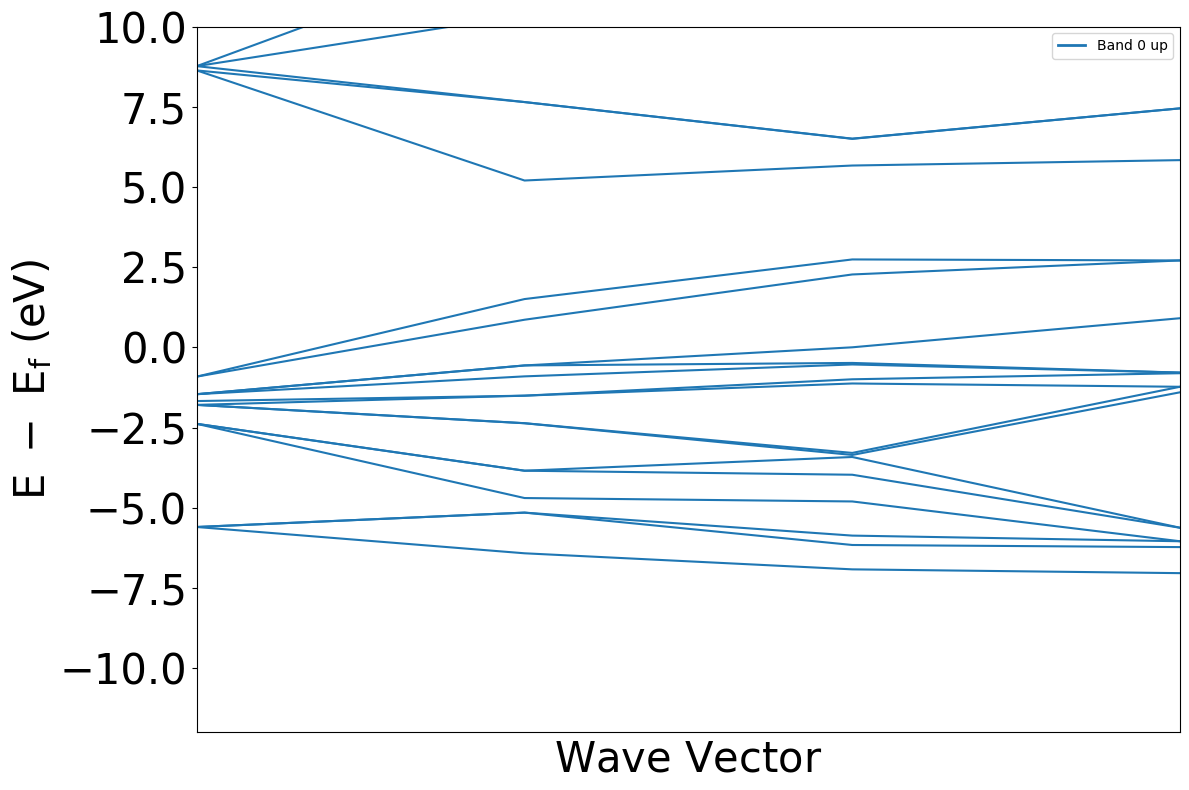

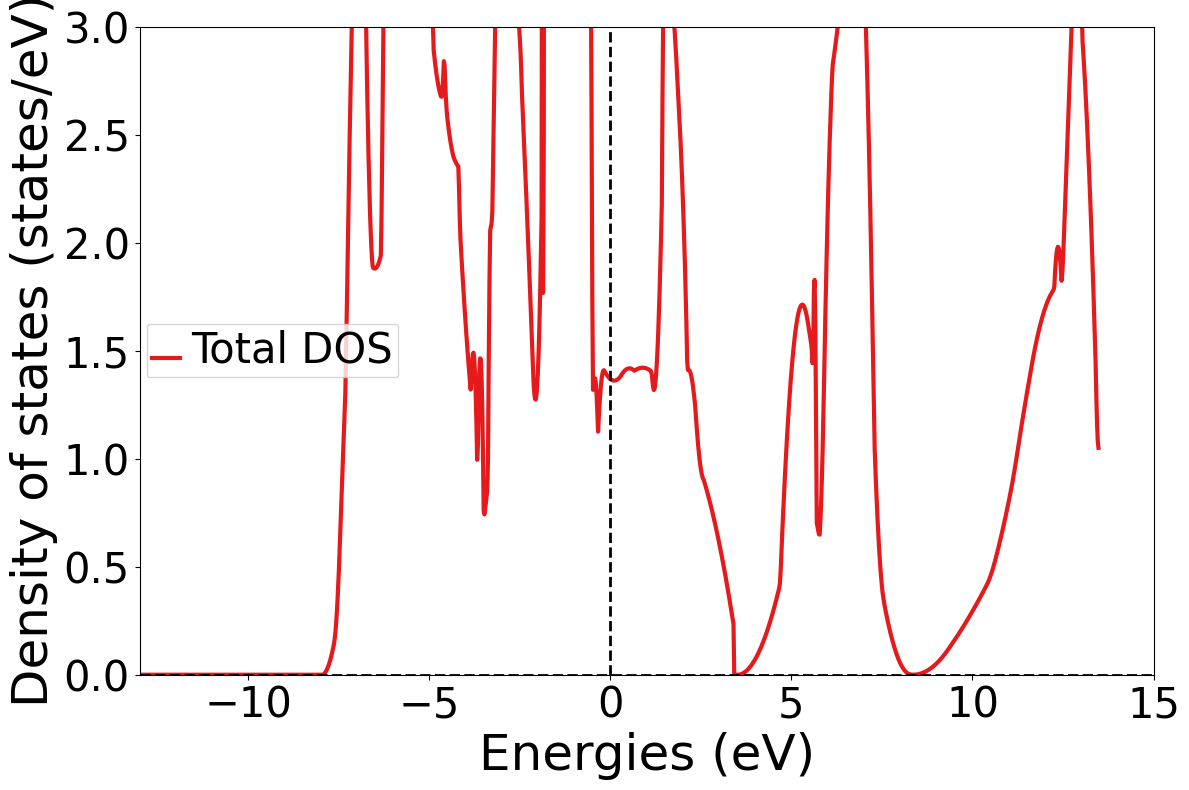

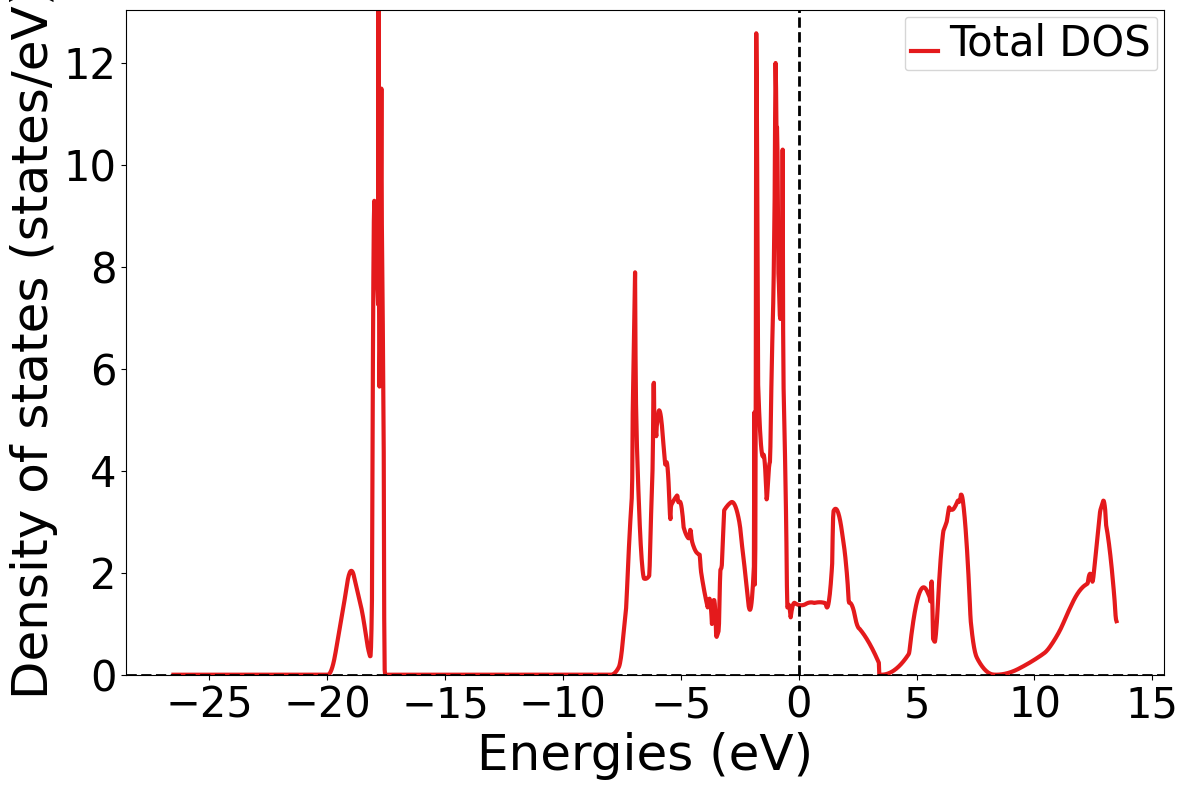

In [21]:
Final_Calculation(material_path=f"/home/student/zylu/materials/{material_id}_{formula}/", material_id=material_id, formula = formula)

# PostProcessing (pymatgen)

## Plot DOS with pymatgen

In [ ]:
from pymatgen.electronic_structure.core import OrbitalType
from pymatgen.electronic_structure.plotter import DosPlotter
from pymatgen.io.vasp.outputs import Vasprun

In [ ]:
# load data
result = Vasprun('/home/student/zylu/silicon_demo/2_dos/vasprun.xml', parse_potcar_file=False)
complete_dos = result.complete_dos
pdos_Si = complete_dos.get_element_spd_dos('Si')

In [ ]:
plotter = DosPlotter()
plotter.add_dos('Total DOS', result.tdos)
plotter.add_dos('Si(s)', pdos_Si[OrbitalType.s])
plotter.add_dos('Si(p)', pdos_Si[OrbitalType.p])

plotter.get_plot(xlim=(-13, 15), ylim=(0, 3))

## Plot Band_structure with pymatgen

In [ ]:
from pymatgen.io.vasp.outputs import Vasprun
from pymatgen.electronic_structure.plotter import BSPlotter

vaspout = Vasprun("/home/student/zylu/silicon_demo/3_bs/vasprun.xml")
bandstr = vaspout.get_band_structure(line_mode=True)
plt = BSPlotter(bandstr).get_plot(ylim=[-12,10])


In [ ]:
from pymatgen.electronic_structure.core import OrbitalType
from pymatgen.electronic_structure.plotter import DosPlotter
from pymatgen.io.vasp.outputs import Vasprun

def plot_dos(material_path: str = ''):
    if not material_path:
        raise ValueError("material_path must be provided.")
# load data
    result = Vasprun(f'{material_path}/2_dos/vasprun.xml', parse_potcar_file=False)
    # complete_dos = result.complete_dos
    # pdos_Si = complete_dos.get_element_spd_dos('Si')

    plotter = DosPlotter()
    plotter.add_dos('Total DOS', result.tdos)
    # plotter.add_dos('Si(s)', pdos_Si[OrbitalType.s])
    # plotter.add_dos('Si(p)', pdos_Si[OrbitalType.p])
    plotter.get_plot(xlim=(-13, 15), ylim=(0, 3))

plot_dos(material_path='/home/student/zylu/silicon_demo')

In [ ]:
from pymatgen.io.vasp.outputs import Vasprun
from pymatgen.electronic_structure.plotter import BSPlotter

def plot_band_structure(material_path: str = ''):
    if not material_path:
        raise ValueError("material_path must be provided.")
    vaspout = Vasprun(f"{material_path}/3_bs/vasprun.xml")
    bandstr = vaspout.get_band_structure(line_mode=True)
    plt = BSPlotter(bandstr).get_plot(ylim=[-12,10])
    return plt
plot_band_structure(material_path='/home/student/zylu/silicon_demo')


# Acutal Lab Calculations

In [ ]:
for doc in docs:
    structure = doc.structure
    formula = doc.formula_pretty
    material_id = doc.material_id

    print(f"Processing material: {material_id}, formula: {formula}, material_id: {material_id}")

In [ ]:
for doc in docs[20:30]:
    structure = doc.structure
    formula = doc.formula_pretty
    material_id = doc.material_id

    print(f"Processing material: {material_id}, formula: {formula}, material_id: {material_id}")

    create_vasp_project(material_id, formula, base_path="/home/student/zylu/materials", POSCAR_content=structure.to(fmt="poscar"))

    Final_Calculation(material_path=f"/home/student/zylu/materials/{material_id}_{formula}/", material_id = material_id, formula = formula)